# Cost-Aware A/B Testing with Bandit Model

## Background

A/B testing (a.k.a. randomized controlled trials, randomized experiments) is one of the most important ways to understand causal relationships. In a typical A/B testing setup, there will be one (or more) treatment group and one control group, and a pool of subjects are randomly assigned to the experimental groups based on pre-determined proportions (e.g., equal assignments). 

While this is a perfectly legitimate way to test causality, it can be inefficient in practice. Imagine a clinical trial of two treatment options: drug A and placebo B, and let's assume that (in fact) drug A is much more effective than placebo B in treating a certain condition. Then, every subject that is assigned to the placebo group has to (unfortunately) endure some non-trivial costs, i.e., their conditions are not treated timely even when an effective drug exists. Note that some of the costs are necessary - after all, we don't know the effectiveness of drug A a priori and need a sufficient number of people in both groups to find out. However, as the effectiveness of drug A becomes clearer and clearer over the course of the experiment, perhaps it makes sense to gradually reduce the assignment to the placebo group, in order to reduce costs. 

This is the basic idea behind **cost-aware A/B testing**. It is an important emerging topic in experimentation, and has attracted a lot of attention from both researchers and practitioners.

## Problem and Task

**Problem Statement**: 

Formally, consider an experiment with $k$ treatment options $\{T_1, \ldots, T_k\}$ (no need to explicitly differentiate between treatment and control in a traditional sense, one of these options could be a control condition). Each of the $k$ treatments has a true underlying treatment effect $\{TE_1, \ldots, TE_k\}$, which is unknown to the experimenter before the experiment is conducted. For an arbitrary subject $i$ that is assigned to a treatment $j$, the realized treatment effect $TE_{ij}$ is a random draw from the normal distribution surrounding the true treatment effect with unknown variance, i.e., $TE_{ij} \sim N(TE_j, \sigma^2_j)$. There are $N$ subjects available in total, who can be assigned to the different treatment groups. The goal of the experimenter is twofold: (1) the experimenter wants to understand the effectiveness of each treatment option (this is why the experiment is conducted in the first place); (2) at the same time, the experimenter wants to be cost-aware in treatment assignment and try to avoid incurring too much costs.

**Your Task**:
1. Formulate the above problem into a specific reinforcement learning problem. Clearly define and articulate the agent, environment, actions, rewards, and the agent's objective, etc.;
2. Create a simulation environment for this problem. This means manually picking some values for the treatment effects, number of subjects, and how the realized treatment effect for each subject should be generated, etc.;
3. Solve the reinforcement learning problem you have formulated in step 1 using multiple methods that may be appropriate. For each method that you choose to use, you need to (1) briefly describe how it works, (2) implement it, and (3) evaluate its performance in the simulation environment that you have created in step 2.
4. **Deliverable**: a PDF file rendered from a Jupyter Notebook that documents your answers, code, and outputs.

# Problem Formulation:

We will use multi-bandit model to formulate the cost-aware A/B testing, where each arm represent the respective medical condition. 

- Agent: The decision maker who allocates subjects to different treatment groups
- Environment: The agent will interact with the environment that consists of treatment outcomes, which include unknown true treatment effects.
- States: The accumulated observation and outcomes from historical assignment.
- Actions: The agenet's decision in each trails of how many and which subjects to assign to each treatment group
- Rewards: Positive rewards for allocations that lead to higher observed treatment effects, negative rewards for allocations that lead to lower ones.
- Objective: Maximize the cumulative reward and consider the statistical comparison

# Solution 1: Epsilon-greedy with t test selection


### Action selection strategy:
Here we utilize epsilon-greedy strategy to do the exploration and exploitation. 
For exploration, with the probability "epsilon"(I set as 0.1), a random arm is chosen to be pulled; and for exploitation, with the probability of "1 - epsilon", the highest adjusted value is chosen.

The adjustment here is done through dividing the current estimated value of the arm by the standard error of the mean (SEM) of the arm's rewards. This division by SEM can be seen as an attempt to normalize the reward estimates by their uncertainty, favoring arms with higher confidence (lower SEM) in their reward estimates. This is an exploitation step, where the algorithm capitalizes on the arms that it currently views as the best options based on past rewards.


### Value Estimation:
Pull Function (pull): When an arm is pulled, the reward is drawn from a normal distribution centered around the true mean of the arm (means[arm]) with a standard deviation equal to the square root of the arm's variance. 

Value Estimation Function (value_est): Here, the new reward is combined with the existing estimate of the arm's value. A weight proportional to the inverse of the SEM squared is assigned to the new reward. This weight signifies how reliable the reward is perceived to be—the smaller the SEM, the greater the weight, and hence, the more impact the new reward has on updating the arm’s value. The updated value of an arm is a weighted average between its previous value and the new reward, factored by their respective weights. This method dynamically adjusts the arm's estimated value based on both the amount and reliability of the data accumulated.


### Statistical Comparison between the k-arms:
After every 10 rounds, starting from round k, we will compare each arm to the best-performing arm based on the adjusted value. Using two-sample t-test, if p-value is lower than 0.05, and the ratio of the best arm's value to its SEM is greater than the same ratio for the other arm, that other arm is removed from the set of active arms.  

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import *

In [178]:
def pull(arm):
    reward = np.random.normal(means[arm], np.sqrt(variances[arm]))
    sem = np.sqrt(variances[arm]) / np.sqrt(counter[arm] + 1)
    return reward, sem

def value_est(curr_values, counter, action, reward, sem):
    # Weight inversely proportional to variance
    weight = 1 / (sem ** 2)
    total_weight = weight + counter[action]
    curr_values[action] = (curr_values[action] * counter[action] + weight * reward) / total_weight
    counter[action] += weight
    return curr_values, counter

In [179]:
k = 10
T = 1000
epsilon = 0.1
np.random.seed(12345)
means = np.random.normal(0, 1, k)
variances = np.abs(np.random.normal(1, 0.04, k))
curr_values = [0]*k
counter = [0]*k
reward_history = [[] for _ in range(k)]
sem = [0]*k
active_arms = list(range(k))
active_arms_history = []
total_rewards_1 =[]
average_rewards_1 = []

In [180]:
print(means)

[-0.20470766  0.47894334 -0.51943872 -0.5557303   1.96578057  1.39340583
  0.09290788  0.28174615  0.76902257  1.24643474]


In [181]:
for t in range(T):
    active_arms_history.append(active_arms.copy())
    
    if np.random.rand() < epsilon:  # Explore
        arm = np.random.choice(active_arms)
    else:  # Exploit
        arm = max(active_arms, key=lambda x: curr_values[x] / (sem[x] if sem[x] > 0 else 1))  # Consider uncertainty in exploitation

    reward, current_sem = pull(arm)
    reward_history[arm].append(reward)
    sem[arm] = current_sem
    curr_values, counter = value_est(curr_values, counter, arm, reward, current_sem)
    
    total_reward_at_t = sum(sum(reward_history[arm]) for arm in range(k))
    total_rewards_1.append(total_reward_at_t)
    average_rewards_1.append(total_reward_at_t / ((t + 1) * k))

    # Statistical comparison every 10 rounds after initial exploration
    if t % 10 == 0 and t >= k:
        best_arm = max(active_arms, key=lambda x: curr_values[x] / (sem[x] if sem[x] > 0 else 1))
        best_arm_value = curr_values[best_arm]
        best_arm_sem = sem[best_arm]
        for other_arm in list(active_arms):
            if other_arm != best_arm and counter[other_arm] > 10:
                stat, p_value = ttest_ind(reward_history[best_arm], reward_history[other_arm], equal_var=False)
                if p_value < 0.05 and best_arm_value / sem[best_arm] > curr_values[other_arm] / sem[other_arm]:
                    active_arms.remove(other_arm)  # Statistically eliminate inferior arms

sum_rewards_1 = [np.sum(history) for history in reward_history]
avg_rewards_1 = [np.mean(history) for history in reward_history]

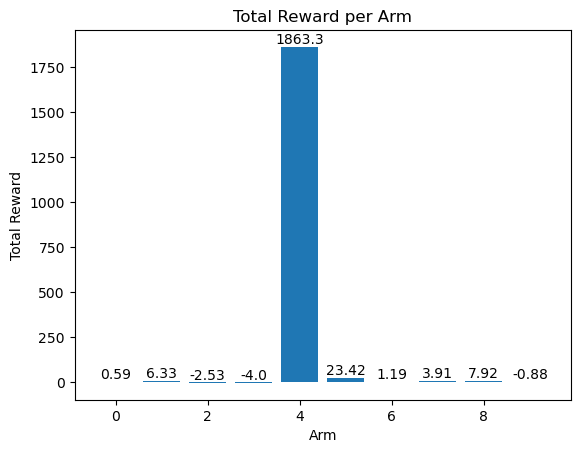

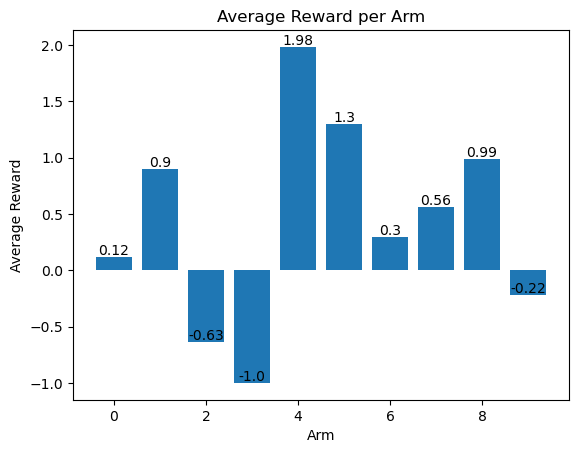

In [182]:
# Plotting Total Reward per Arm 
plt.bar(range(k), sum_rewards_1)
plt.title("Total Reward per Arm")
plt.xlabel("Arm")
plt.ylabel("Total Reward")

# Adding the text annotation on top of the bars
for i, v in enumerate(sum_rewards_1):
    plt.text(i, v + max(sum_rewards_1) * 0.01, str(round(v, 2)), color='black', ha='center')

plt.show()

# Plotting Average Reward per Arm 
plt.bar(range(k), avg_rewards_1)
plt.title("Average Reward per Arm")
plt.xlabel("Arm")
plt.ylabel("Average Reward")

# Adding the text annotation on top of the bars
for i, v in enumerate(avg_rewards_1):
    plt.text(i, v + max(avg_rewards_1) * 0.01, str(round(v, 2)), color='black', ha='center')

plt.show()

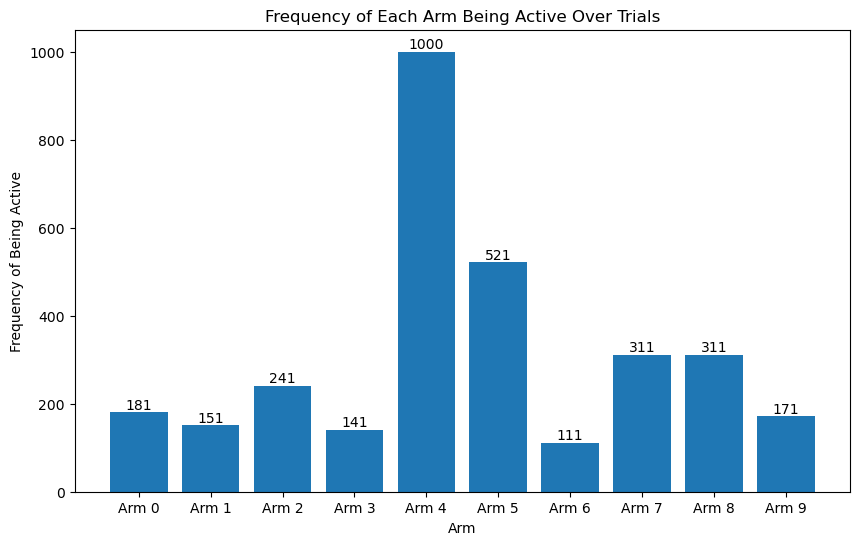

In [183]:
arm_frequencies = np.zeros(k)
for active_arms in active_arms_history:
    for arm in active_arms:
        arm_frequencies[arm] += 1

# Plotting the frequency of each arm being active with labels on the bars
plt.figure(figsize=(10, 6))
bars = plt.bar(range(k), arm_frequencies)
plt.xlabel('Arm')
plt.ylabel('Frequency of Being Active')
plt.title('Frequency of Each Arm Being Active Over Trials')
plt.xticks(range(k), [f'Arm {i}' for i in range(k)])

# Adding frequency labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

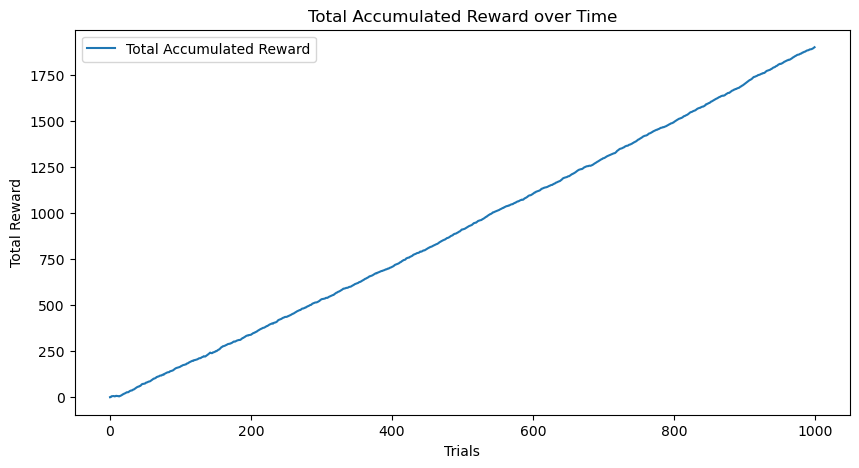

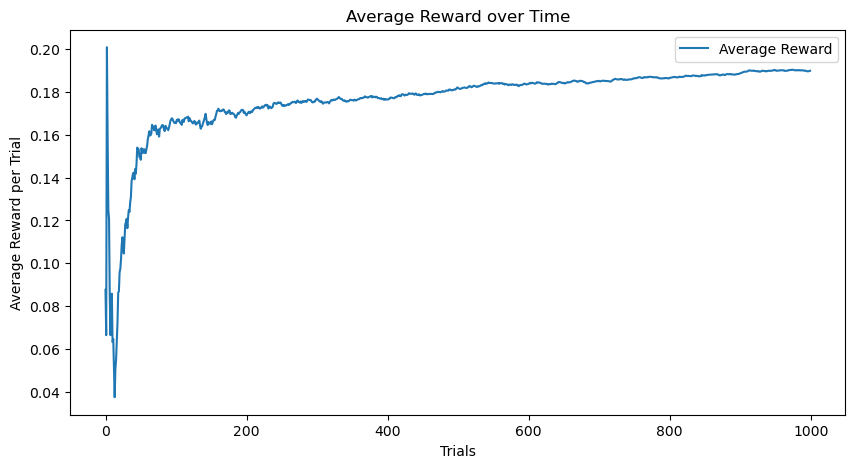

In [184]:
plt.figure(figsize=(10, 5))
plt.plot(total_rewards_1, label='Total Accumulated Reward')
plt.title('Total Accumulated Reward over Time')
plt.xlabel('Trials')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(average_rewards_1, label='Average Reward')
plt.title('Average Reward over Time')
plt.xlabel('Trials')
plt.ylabel('Average Reward per Trial')
plt.legend()
plt.show()

# Solution 2: Epsilon-greedy with Mann-Whitney U test selection 

We use the same action-value calculation in solution 1 but different arm elimination approach. In this solution, we use Mann-Whitney to elimiate the low reward arms over the 1000 trails.
While t-test asssumes that the data are normally distributed within each group being compared,the Mann-Whitney U test does not assume that the data follow a normal distribution. It is a non-parametric test, making it suitable for comparing groups with skewed distributions or ordinal data. Hence it is preferable if we are not sure about the reward distribution and increase the robustness of the statistical test.

In [217]:
def pull(arm):
    reward = np.random.normal(means[arm], np.sqrt(variances[arm]))
    sem = np.sqrt(variances[arm]) / np.sqrt(counter[arm] + 1)
    return reward, sem

def value_est(curr_values, counter, action, reward, sem):
    # Weight inversely proportional to variance
    weight = 1 / (sem ** 2)
    total_weight = weight + counter[action]
    curr_values[action] = (curr_values[action] * counter[action] + weight * reward) / total_weight
    counter[action] += weight
    return curr_values, counter

In [218]:
k = 10
T = 1000
epsilon = 0.1
np.random.seed(12345)
means = np.random.normal(0, 1, k)
variances = np.abs(np.random.normal(1, 0.04, k))
curr_values = [0]*k
counter = [0]*k
reward_history = [[] for _ in range(k)]
sem = [0]*k
active_arms = list(range(k))
active_arms_history = []
total_reward_2 = [0]
average_reward_2 = []

In [214]:
print(means)

[-0.20470766  0.47894334 -0.51943872 -0.5557303   1.96578057  1.39340583
  0.09290788  0.28174615  0.76902257  1.24643474]


In [219]:
for t in range(T):
    active_arms_history.append(active_arms.copy())
    
    if np.random.rand() < epsilon:  # Explore
        arm = np.random.choice(active_arms)
    else:  # Exploit
        arm = max(active_arms, key=lambda x: curr_values[x] / (sem[x] if sem[x] > 0 else 1))  # Consider uncertainty in exploitation

    reward, current_sem = pull(arm)
    reward_history[arm].append(reward)
    sem[arm] = current_sem
    curr_values, counter = value_est(curr_values, counter, arm, reward, current_sem)
    
    total_reward_2.append(total_reward_2[-1] + reward) 
    average_reward_2.append(total_reward_2[-1] / ((t + 1) * k))

    # Statistical comparison every 10 rounds after initial exploration
    if t % 10 == 0 and t >= k:
        best_arm = max(active_arms, key=lambda x: curr_values[x] / (sem[x] if sem[x] > 0 else 1))
        for other_arm in list(active_arms):
            if other_arm != best_arm and len(reward_history[other_arm]) > 10 and len(reward_history[best_arm]) > 10:
                u_stat, p_value = mannwhitneyu(reward_history[best_arm], reward_history[other_arm], alternative='greater')
                if p_value < 0.05:  
                    active_arms.remove(other_arm)

sum_rewards_2 = [np.sum(history) for history in reward_history]
avg_rewards_2 = [np.mean(history) for history in reward_history]

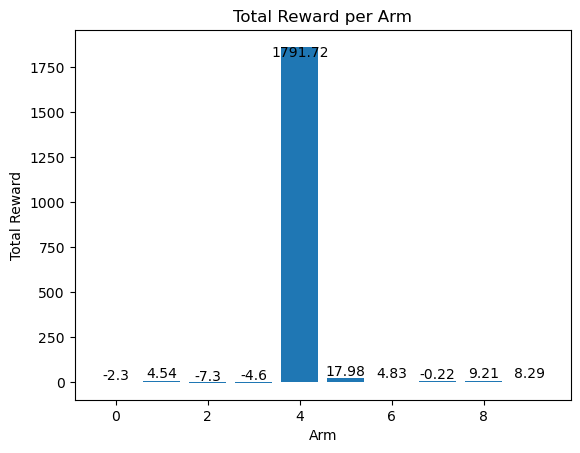

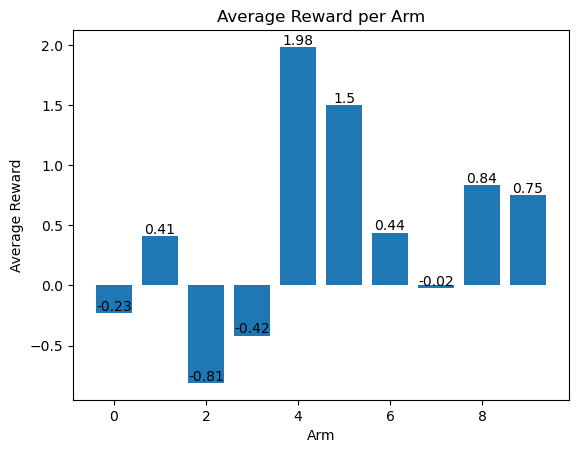

In [205]:
# Plotting Total Reward per Arm 
plt.bar(range(k), sum_rewards)
plt.title("Total Reward per Arm")
plt.xlabel("Arm")
plt.ylabel("Total Reward")

# Adding the text annotation on top of the bars
for i, v in enumerate(sum_rewards_2):
    plt.text(i, v + max(sum_rewards_2) * 0.01, str(round(v, 2)), color='black', ha='center')

plt.show()

# Plotting Average Reward per Arm 
plt.bar(range(k), avg_rewards_2)
plt.title("Average Reward per Arm")
plt.xlabel("Arm")
plt.ylabel("Average Reward")

# Adding the text annotation on top of the bars
for i, v in enumerate(avg_rewards_2):
    plt.text(i, v + max(avg_rewards_2) * 0.01, str(round(v, 2)), color='black', ha='center')

plt.show()

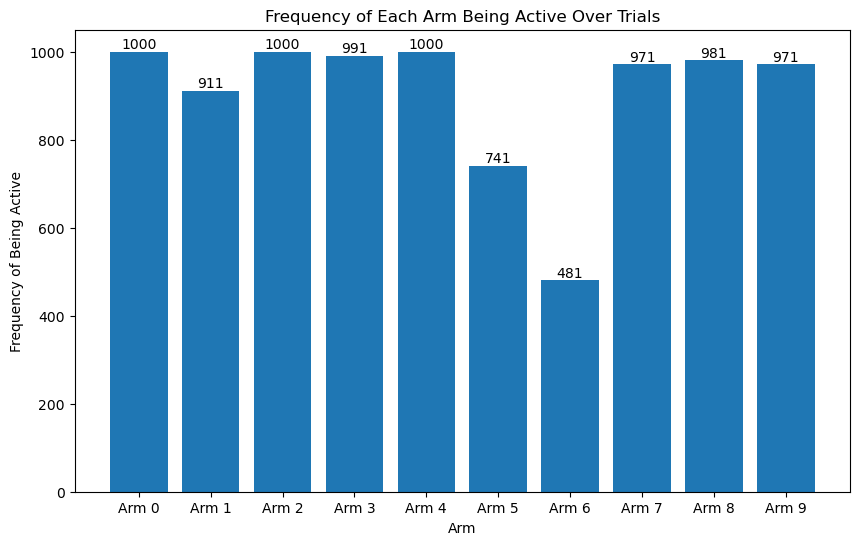

In [206]:
arm_frequencies = np.zeros(k)
for active_arms in active_arms_history:
    for arm in active_arms:
        arm_frequencies[arm] += 1

# Plotting the frequency of each arm being active with labels on the bars
plt.figure(figsize=(10, 6))
bars = plt.bar(range(k), arm_frequencies)
plt.xlabel('Arm')
plt.ylabel('Frequency of Being Active')
plt.title('Frequency of Each Arm Being Active Over Trials')
plt.xticks(range(k), [f'Arm {i}' for i in range(k)])

# Adding frequency labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

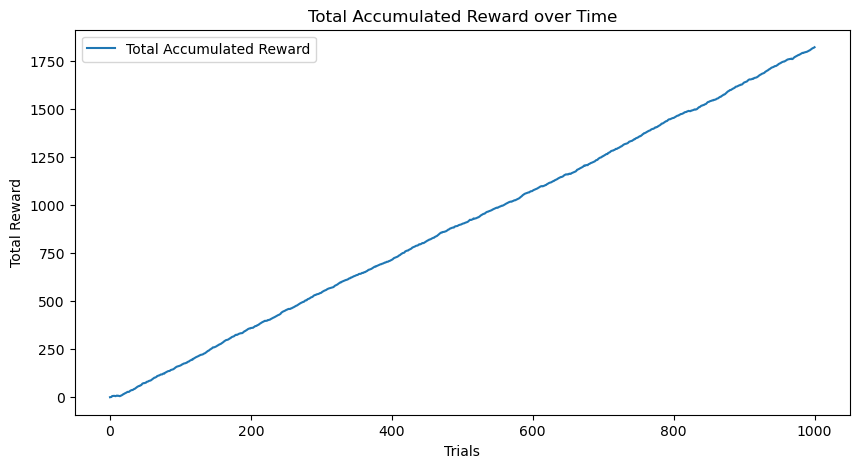

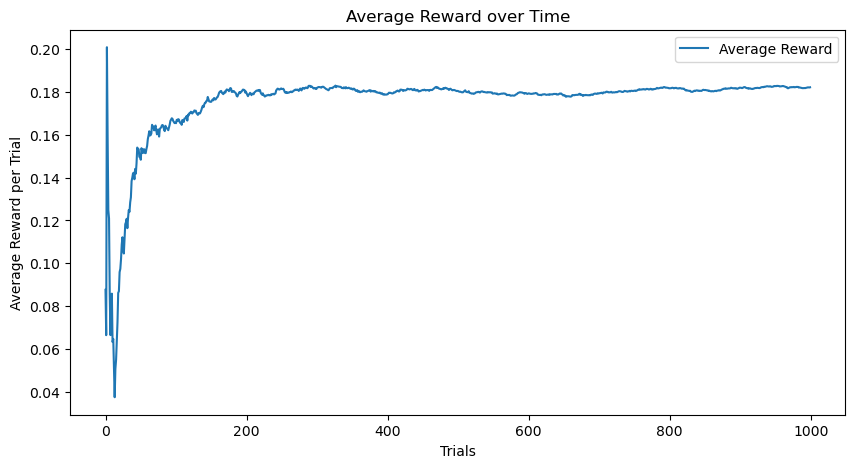

In [208]:
plt.figure(figsize=(10, 5))
plt.plot(total_reward_2, label='Total Accumulated Reward')
plt.title('Total Accumulated Reward over Time')
plt.xlabel('Trials')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(average_reward_2, label='Average Reward')
plt.title('Average Reward over Time')
plt.xlabel('Trials')
plt.ylabel('Average Reward per Trial')
plt.legend()
plt.show()

# Solution 3: UCB with Mann-Whitney U test selection¶

This solution replace the Epsilon-Greedy with UCB by adding the parameter c to control the degree of exploration the algorithm takes. It helps to balance the trade of between exploration and exploitation. Here we set c as 1 to see the performance.

In [232]:
def pull(arm):
    reward = np.random.normal(means[arm], np.sqrt(variances[arm]))
    sem = np.sqrt(variances[arm]) / np.sqrt(counter[arm] + 1)
    return reward, sem

def value_est(curr_values, counter, action, reward, sem):
    # Weight inversely proportional to variance
    weight = 1 / (sem ** 2)
    total_weight = weight + counter[action]
    curr_values[action] = (curr_values[action] * counter[action] + weight * reward) / total_weight
    counter[action] += weight
    return curr_values, counter

In [248]:
k = 10
T = 1000
c = 1  # Exploration parameter for UCB
np.random.seed(12345)
means = np.random.normal(0, 1, k)
variances = np.abs(np.random.normal(1, 0.04, k))
curr_values = [0]*k
counter = [0]*k
reward_history = [[] for _ in range(k)]
sem = [0]*k
active_arms = list(range(k))
active_arms_history = []
total_reward_3 = [0]
average_reward_3 = []

In [249]:
for t in range(T):
    active_arms_history.append(active_arms.copy())
    
    if t < k:  # Ensure each arm is tried at least once
        arm = t
    else:
        ucb_values = [curr_values[i] + c * np.sqrt(np.log(t+1) / (counter[i] if counter[i] > 0 else 1)) for i in range(k)]
        arm = np.argmax(ucb_values)  # Select the arm with the highest UCB value

    reward, current_sem = pull(arm)
    reward_history[arm].append(reward)
    sem[arm] = current_sem
    curr_values, counter = value_est(curr_values, counter, arm, reward, current_sem)
    
    total_reward_3.append(total_reward_3[-1] + reward) 
    average_reward_3.append(total_reward_3[-1] / ((t + 1) * k))

    # Statistical comparison every 10 rounds after initial exploration
    if t % 10 == 0 and t >= k:
        best_arm = np.argmax([curr_values[i] + c * np.sqrt(np.log(t+1) / (counter[i] if counter[i] > 0 else 1)) for i in range(k)])
        for other_arm in list(active_arms):
            if other_arm != best_arm and len(reward_history[other_arm]) > 10 and len(reward_history[best_arm]) > 10:
                u_stat, p_value = mannwhitneyu(reward_history[best_arm], reward_history[other_arm], alternative='greater')
                if p_value < 0.05:  
                    active_arms.remove(other_arm)

sum_rewards_3 = [np.sum(history) for history in reward_history]
avg_rewards_3 = [np.mean(history) for history in reward_history]

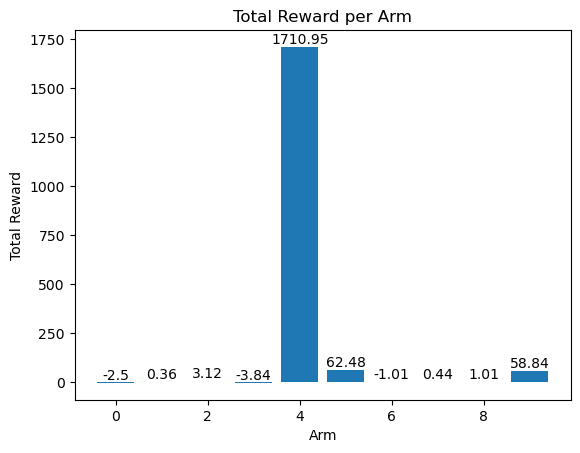

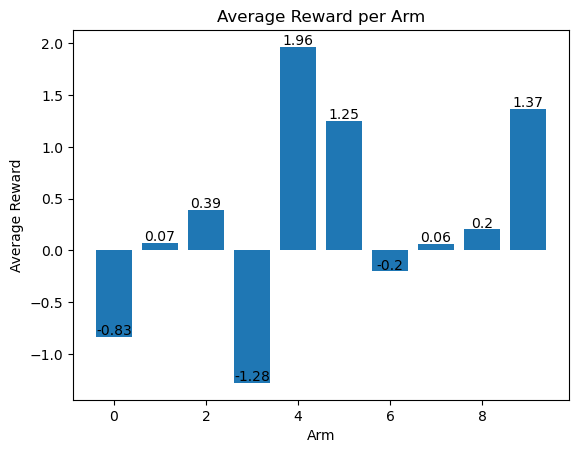

In [250]:
# Plotting Total Reward per Arm 
plt.bar(range(k), sum_rewards_3)
plt.title("Total Reward per Arm")
plt.xlabel("Arm")
plt.ylabel("Total Reward")

# Adding the text annotation on top of the bars
for i, v in enumerate(sum_rewards_3):
    plt.text(i, v + max(sum_rewards_3) * 0.01, str(round(v, 2)), color='black', ha='center')

plt.show()

# Plotting Average Reward per Arm 
plt.bar(range(k), avg_rewards_3)
plt.title("Average Reward per Arm")
plt.xlabel("Arm")
plt.ylabel("Average Reward")

# Adding the text annotation on top of the bars
for i, v in enumerate(avg_rewards_3):
    plt.text(i, v + max(avg_rewards_3) * 0.01, str(round(v, 2)), color='black', ha='center')

plt.show()

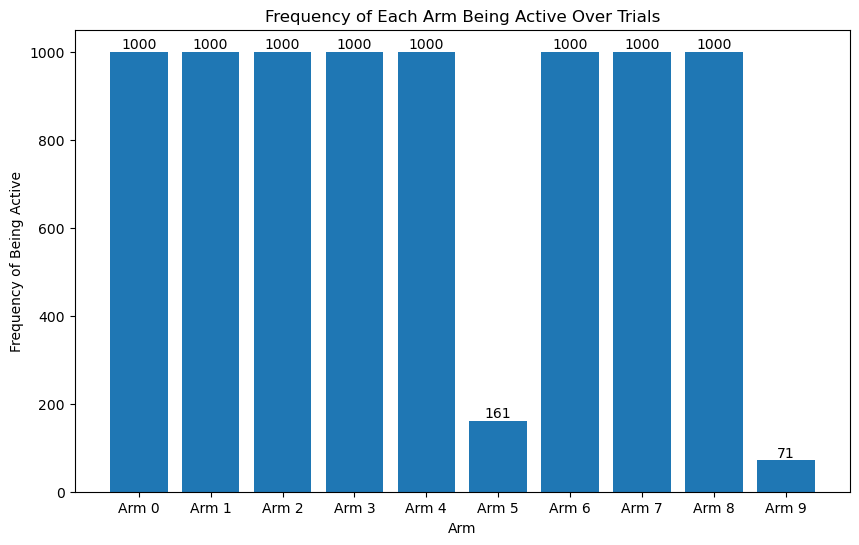

In [251]:
arm_frequencies = np.zeros(k)
for active_arms in active_arms_history:
    for arm in active_arms:
        arm_frequencies[arm] += 1

# Plotting the frequency of each arm being active with labels on the bars
plt.figure(figsize=(10, 6))
bars = plt.bar(range(k), arm_frequencies)
plt.xlabel('Arm')
plt.ylabel('Frequency of Being Active')
plt.title('Frequency of Each Arm Being Active Over Trials')
plt.xticks(range(k), [f'Arm {i}' for i in range(k)])

# Adding frequency labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

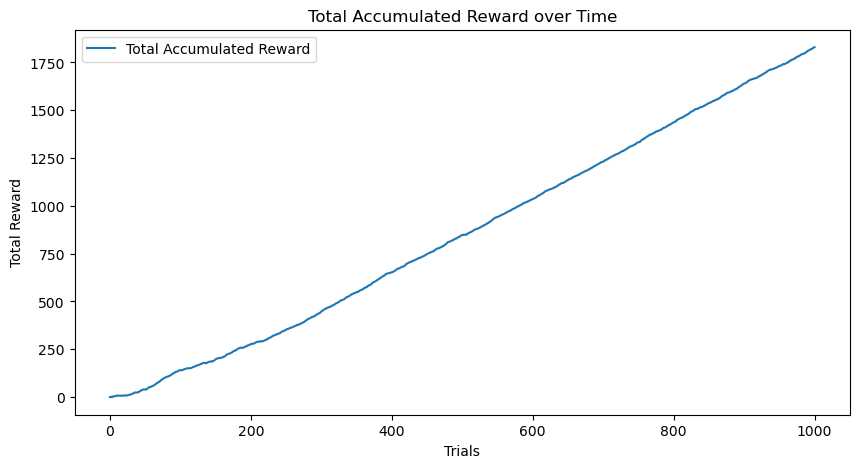

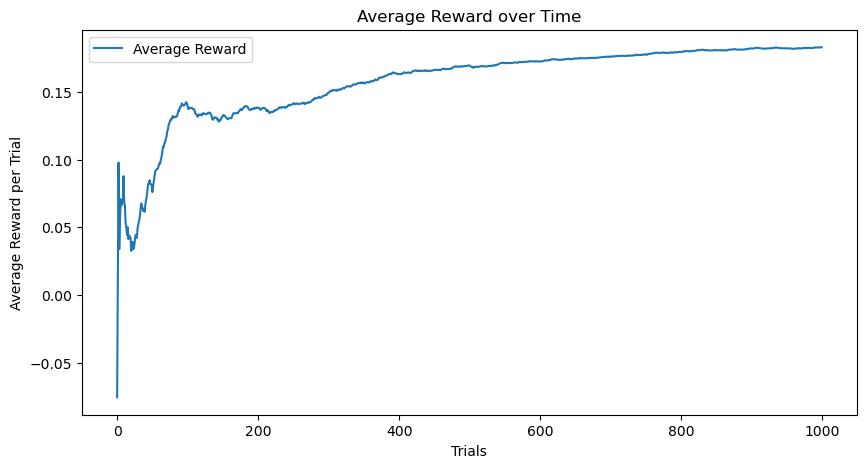

In [252]:
plt.figure(figsize=(10, 5))
plt.plot(total_reward_3, label='Total Accumulated Reward')
plt.title('Total Accumulated Reward over Time')
plt.xlabel('Trials')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(average_reward_3, label='Average Reward')
plt.title('Average Reward over Time')
plt.xlabel('Trials')
plt.ylabel('Average Reward per Trial')
plt.legend()
plt.show()

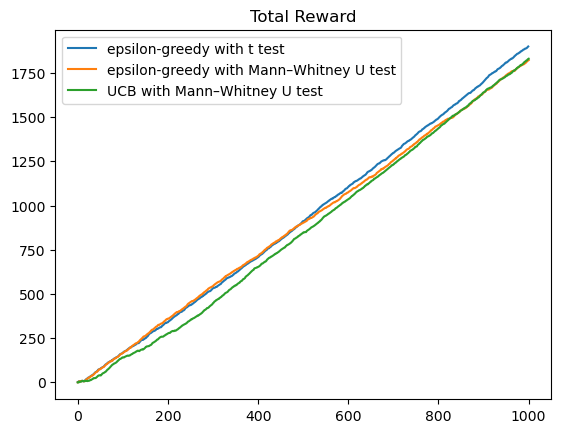

In [253]:
# Let's plot the sum and average reward over 1000 rounds
plt.plot(total_rewards_1)
plt.plot(total_reward_2)
plt.plot(total_reward_3)
plt.title("Total Reward")
plt.legend(["epsilon-greedy with t test", "epsilon-greedy with Mann–Whitney U test", "UCB with Mann–Whitney U test"])
plt.show()

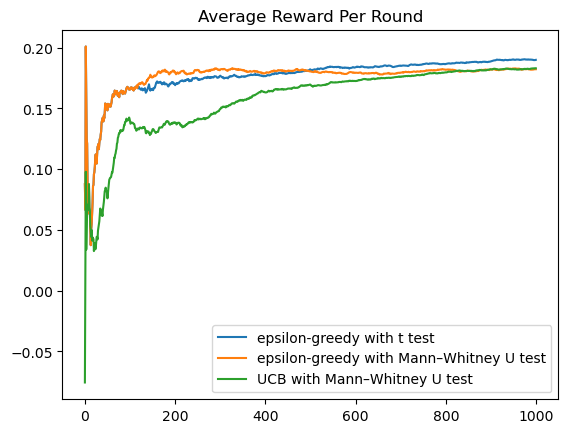

In [254]:
plt.plot(average_rewards_1)
plt.plot(average_reward_2)
plt.plot(average_reward_3)
plt.title("Average Reward Per Round")
plt.legend(["epsilon-greedy with t test", "epsilon-greedy with Mann–Whitney U test", "UCB with Mann–Whitney U test"])
plt.show()